<a href="https://colab.research.google.com/github/milioe/Moravec/blob/main/3_ComputerVision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Classification

* Classification with more data (our own models)
* Metrics (Precision // Recall // F1)
* Transfer Learning 
* **Weights and biases** vs TensorBoard
* Callbacks (Epochs, WB, checkpoints)
* Gradio // Hugging Faces
* Anaconda environment

In [ ]:
import zipfile

# Download zip file of 10_food_classes images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

--2022-07-23 19:48:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   238MB/s    in 2.1s    

2022-07-23 19:48:12 (238 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [ ]:
# Unzip
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r") # r = read // w = write // a = append // b // wr
zip_ref.extractall()
zip_ref.close() # 

In [ ]:
import os # through system

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.

In [ ]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0]) # target_folder/test/00001.jpg
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Image shape: (384, 512, 3)


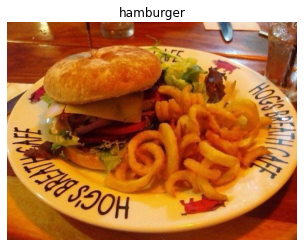

In [ ]:
# View a random image from the training dataset
import random
img = view_random(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Baseline

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [ ]:
# install wandb
!pip install wandb -q 

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
# Login
# wandb.login()

In [ ]:
# WB
# Project = repository
run = wandb.init(project="ComputerVision", name="model_0", config={"learning_rate":0.001, "epochs":5})


# set random
tf.random.set_seed(42)

# 1. Create model
model_0 = Sequential([
  Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation="softmax")
])

# 2. Compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# 3. Fit model 
model_0.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
            validation_data=test_data, validation_steps=len(test_data),
            callbacks=[WandbCallback(monitor="val_loss")])

run.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/5
235/235 [==============================] - 61s 201ms/step - loss: 2.1312 - accuracy: 0.2257 - precision: 0.5128 - recall: 0.0080 - val_loss: 2.0409 - val_accuracy: 0.2580 - val_precision: 0.5294 - val_recall: 0.0108 - _timestamp: 1658601308.0000 - _runtime: 68.0000
Epoch 2/5
235/235 [==============================] - 47s 199ms/step - loss: 1.9141 - accuracy: 0.3241 - precision: 0.6197 - recall: 0.0521 - val_loss: 1.9994 - val_accuracy: 0.3000 - val_precision: 0.4783 - val_recall: 0.1060 - _timestamp: 1658601355.0000 - _runtime: 115.0000
Epoch 3/5
235/235 [==============================] - 46s 195ms/step - loss: 1.5795 - accuracy: 0.4544 - precision: 0.6985 - recall: 0.1977 - val_loss: 2.1044 - val_accuracy: 0.2820 - val_precision: 0.3857 - val_recall: 0.0884 - _timestamp: 1658601400.0000 - _runtime: 160.0000
Epoch 4/5
235/235 [==============================] - 46s 194ms/step - loss: 1.029

accuracy,▁▂▄▆█
epoch,▁▃▅▆█
loss,█▇▆▃▁
precision,▁▃▄▆█
recall,▁▁▃▅█
val_accuracy,▃█▆▄▁
val_loss,▁▁▁▄█
val_precision,█▇▄▃▁
val_recall,▁▅▄▇█
GFLOPS,0.07866
accuracy,0.85027


# Model 1

In [ ]:
config={"learning_rate":0.001, "epochs":5}
run = wandb.init(project="ComputerVision", name="model_1", config=config)

# random seed
tf.random.set_seed(42)

# Create model
model_1 = Sequential([
  Conv2D(10, 3, activation="relu", input_shape=(224,224,3)),
  MaxPool2D(),
  Conv2D(10,3,activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation="softmax")
])

# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Fit model
model_1.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
            validation_data=test_data, validation_steps=len(test_data),
            callbacks=[WandbCallback(monitor="val_loss")])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/5
235/235 [==============================] - 56s 223ms/step - loss: 2.0946 - accuracy: 0.2428 - precision: 0.5018 - recall: 0.0191 - val_loss: 1.9442 - val_accuracy: 0.3244 - val_precision: 0.6742 - val_recall: 0.0240 - _timestamp: 1658605823.0000 - _runtime: 57.0000
Epoch 2/5
235/235 [==============================] - 44s 189ms/step - loss: 1.7919 - accuracy: 0.3877 - precision: 0.6730 - recall: 0.0993 - val_loss: 1.8542 - val_accuracy: 0.3616 - val_precision: 0.6414 - val_recall: 0.0880 - _timestamp: 1658605867.0000 - _runtime: 101.0000
Epoch 3/5
235/235 [==============================] - 44s 187ms/step - loss: 1.4583 - accuracy: 0.5239 - precision: 0.7663 - recall: 0.2317 - val_loss: 1.8668 - val_accuracy: 0.3752 - val_precision: 0.5289 - val_recall: 0.1720 - _timestamp: 1658605949.0000 - _runtime: 183.0000
Epoch 4/5
235/235 [==============================] - 46s 197ms/step - loss: 1.030

# Augmented data

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)


train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="categorical")

Found 7500 images belonging to 10 classes.


Model 2

In [ ]:
# Run 
run = wandb.init(project="ComputerVision", name="model_2", config={"learning_rate":0.001, "epochs":10, "dataset": "augmented"}, tags=["first run", "augmented"])



# Clone model
model_2 = tf.keras.models.clone_model(model_1) # clone architecture


# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Fit the model
model_2.fit(train_data_augmented,
            epochs=10,
            steps_per_epoch=len(train_data_augmented),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks=[WandbCallback(monitor="val_loss")])

run.finish()

accuracy,▁▃▄▆█
epoch,▁▃▅▆█
loss,█▇▅▃▁
precision,▁▄▅▇█
recall,▁▂▃▆█
val_accuracy,▂▆█▁▁
val_loss,▂▁▁▄█
val_precision,█▇▅▂▁
val_recall,▁▃▆▆█
GFLOPS,0.0249
accuracy,0.82707


Epoch 1/10
235/235 [==============================] - 109s 462ms/step - loss: 2.2109 - accuracy: 0.1857 - precision: 0.4390 - recall: 0.0024 - val_loss: 2.0078 - val_accuracy: 0.2832 - val_precision: 0.5085 - val_recall: 0.0120 - _timestamp: 1658606203.0000 - _runtime: 110.0000
Epoch 2/10
235/235 [==============================] - 108s 461ms/step - loss: 2.0721 - accuracy: 0.2564 - precision: 0.4946 - recall: 0.0121 - val_loss: 1.9682 - val_accuracy: 0.2924 - val_precision: 0.6531 - val_recall: 0.0128 - _timestamp: 1658606312.0000 - _runtime: 219.0000
Epoch 3/10
235/235 [==============================] - 108s 459ms/step - loss: 2.0300 - accuracy: 0.2871 - precision: 0.5039 - recall: 0.0172 - val_loss: 1.9183 - val_accuracy: 0.3292 - val_precision: 0.5658 - val_recall: 0.0516 - _timestamp: 1658606420.0000 - _runtime: 327.0000
Epoch 4/10
235/235 [==============================] - 108s 460ms/step - loss: 1.9946 - accuracy: 0.2989 - precision: 0.5301 - recall: 0.0293 - val_loss: 1.8773 - v

accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
precision,▁▃▃▄▅▅▇█▇█
recall,▁▂▂▄▄▅▆▇▇█
val_accuracy,▁▂▄▅▇█▇██▆
val_loss,█▇▅▄▃▁▂▂▂▃
val_precision,▁█▄▃▆█▇▃▄▄
val_recall,▁▁▃▄▅▄▅▆▇█
GFLOPS,0.0249
accuracy,0.34667


In [ ]:
def load_and_prepare_img(filename, img_shape=224):
  # read in target file
  img = tf.io.read_file(filename)

  # Decode the read image into a tensor and ensure it has 3 colour channels
  img = tf.image.decode_image(img, channels=3)

  # Resize image to the same size we've trained our model 
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Rescale the image 
  img = img/255

  return img

In [ ]:
def pred_plot(model, filename, class_names):
  img = load_and_prepare_img(filename)

  pred = model.predict(tf.expand_dims(img, axis=0))

  pred_class = class_names[tf.argmax(tf.squeeze(model_2.predict(tf.expand_dims(load_and_prepare_img("icecream.jpeg"), axis=0))))]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  plt.show();

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

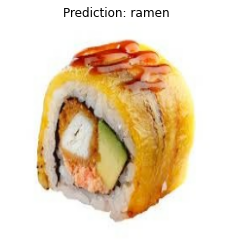

In [ ]:
pred_plot(model_2, "sushi.jpeg", class_names)